In [135]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [136]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation
from endoutbreakvbd.chikungunya import get_data, get_parameters
from endoutbreakvbd.inference import fit_periodic_model, fit_random_walk_model
from endoutbreakvbd.utils import month_start_xticks

In [137]:
df = get_data()
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rep_no_func = parameters["rep_no_func"]
rep_no_func_doy = parameters["rep_no_func_doy"]

rng = np.random.default_rng(2)

In [138]:
doy_start = df["doy"].to_numpy()[0]
incidence_vec = np.append(df["cases"].to_numpy(), np.zeros(100))
doy_vec = np.arange(doy_start, doy_start + len(incidence_vec))


In [139]:
idata = fit_periodic_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    doy_start=doy_start,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_max, rep_no_amplitude, doy_max]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 1472 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'rep_no_max'}>,
        <Axes: title={'center': 'rep_no_max'}>],
       [<Axes: title={'center': 'rep_no_amplitude'}>,
        <Axes: title={'center': 'rep_no_amplitude'}>],
       [<Axes: title={'center': 'doy_max'}>,
        <Axes: title={'center': 'doy_max'}>]], dtype=object)

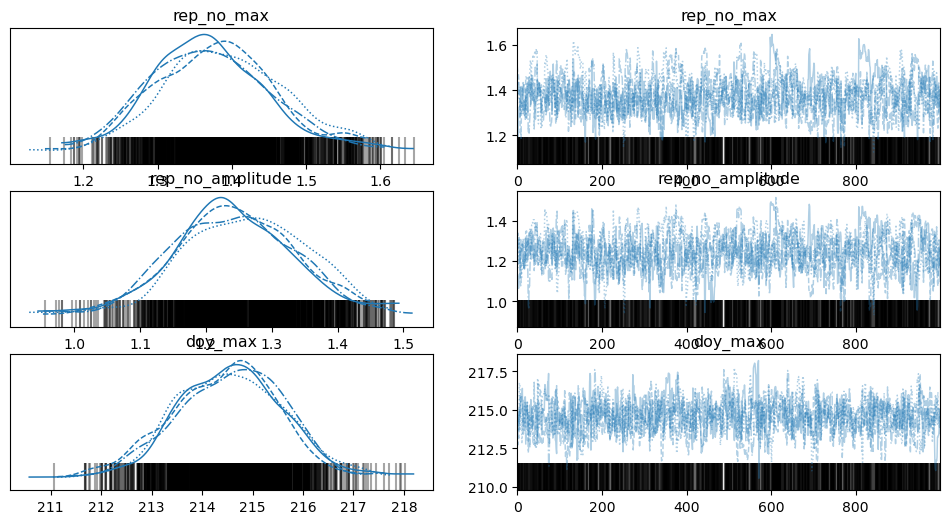

In [140]:
az.plot_trace(idata, var_names=["rep_no_max", "rep_no_amplitude", "doy_max"])

In [141]:
idata2 = fit_random_walk_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    random_walk_sd=0.1,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_start, rep_no_jumps]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


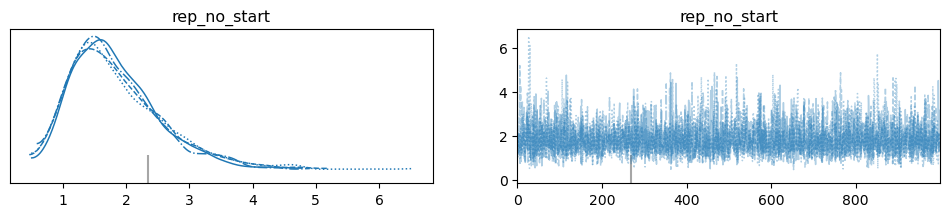

In [142]:
az.plot_trace(idata2, var_names=["rep_no_start"]);

In [143]:
rep_no_max = idata.posterior["rep_no_max"].mean().item()
rep_no_amplitude = idata.posterior["rep_no_amplitude"].mean().item()
doy_max = idata.posterior["doy_max"].mean().item()


def rep_no_func_doy_estim(doy):
    return np.maximum(
        rep_no_max
        - rep_no_amplitude
        + rep_no_amplitude * np.cos(2 * np.pi * (doy - doy_max) / 365),
        0,
    )

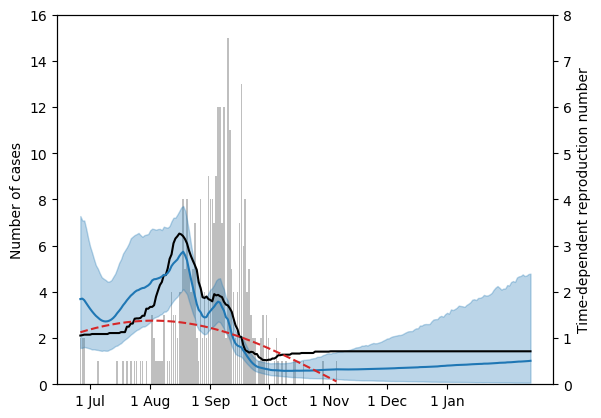

In [144]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.doy, df["cases"], color="gray", alpha=0.5)
ax2.plot(doy_vec, rep_no_func_doy(doy_vec), color="black")
ax2.plot(
    doy_vec,
    idata2.posterior["rep_no_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
ax2.fill_between(
    doy_vec,
    np.percentile(idata2.posterior["rep_no_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata2.posterior["rep_no_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)
ax2.plot(df.doy, rep_no_func_doy_estim(df.doy), "--", color="tab:red")

month_start_xticks(ax, interval_months=1)
ax.set_ylim(0, 16)
ax2.set_ylim(0, 8)
ax.set_ylabel("Number of cases")
ax2.set_ylabel("Time-dependent reproduction number");

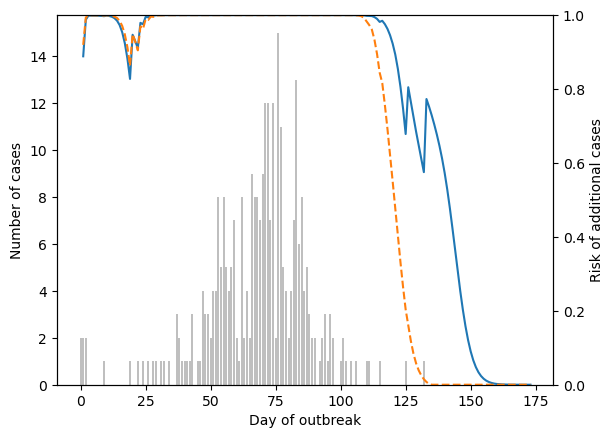

In [145]:
incidence_vec = df["cases"].to_numpy()


fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(
    np.arange(len(incidence_vec)),
    incidence_vec,
    color="gray",
    alpha=0.5,
)
eop_days = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
eop_vals = eop_analytical(
    incidence_vec=incidence_vec,
    rep_no_func=rep_no_func,
    gen_time_dist_vec=gen_time_dist_vec,
    t_calc=eop_days,
)
ax2.plot(
    eop_days,
    1 - eop_vals,
)
ax2.plot(
    eop_days,
    1
    - eop_analytical(
        incidence_vec=incidence_vec,
        rep_no_func=lambda t: rep_no_func_doy_estim(doy_start + t),
        gen_time_dist_vec=gen_time_dist_vec,
        t_calc=eop_days,
    ),
    "--",
)
# eop_days_sim = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
# eop_vals_sim = eop_simulation(
#     incidence_vec=incidence_vec,
#     rep_no_func=rep_no_func,
#     gen_time_dist_vec=gen_time_dist_vec,
#     t_calc=eop_days_sim,
#     n_sims=1000,
#     rng=rng,
# )
# ax2.plot(eop_days_sim, 1 - eop_vals_sim, ".")
ax2.set_ylim(0, 1)
ax.set_xlabel("Day of outbreak")
ax.set_ylabel("Number of cases")
ax2.set_ylabel("Risk of additional cases");